In [1]:
import sys
sys.path.append('..')

In [2]:
import re
from collections import defaultdict
from pathlib import Path
from datetime import datetime, timedelta

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

from myutils.json import load_json
from myutils.colors import COLOR_NAMES

from src.pca import IPCA
from src.rzd import PlacePriceModel

%config InlineBackend.figure_formats = ['svg']

In [3]:
data_dir = Path('../data/2021_05_18/')
fname_re = re.compile('([^-]+)-([^-]+)-(price|place).csv')

places = pd.DataFrame()
prices = pd.DataFrame()

for fpath in data_dir.iterdir():
    df = pd.read_csv(fpath, encoding='cp1251', sep=';', index_col=0).T
    df.index = pd.to_datetime(df.index)
    df.columns.name = None
    
    num, cl, kind = fname_re.fullmatch(fpath.name).groups()
    
    if kind == 'place':
        df = df / df.max().max()
        
    else:  # prices
        df = df.replace(0, np.nan)
    
    df['num'] = num
    df['class'] = cl
    df = df.reset_index().rename(columns={'index': 'date'})
    
    if kind == 'place':
        places = places.append(df, ignore_index=True)
    
    else:  # prices
        prices = prices.append(df, ignore_index=True)
        
places = places.sort_values(by=['num', 'class', 'date']).set_index(['num', 'class', 'date'])
prices = prices.sort_values(by=['num', 'class', 'date']).set_index(['num', 'class', 'date'])

places.head()

1         2         3         4         5   \
num  class date                                                           
752А B1    2021-04-03  0.529412  0.529412  0.764706  0.882353  1.000000   
           2021-04-04  0.823529  0.823529  0.823529  0.823529  0.823529   
           2021-04-05  0.000000  0.000000  0.000000  0.294118  0.352941   
           2021-04-06  0.235294  0.176471  0.176471  0.352941  0.647059   
           2021-04-07  0.705882  0.705882  0.764706  0.764706  0.764706   

                             6         7         8         9         10  
num  class date                                                          
752А B1    2021-04-03  1.000000  1.000000  1.000000  1.000000  1.000000  
           2021-04-04  0.823529  0.823529  0.823529  0.823529  0.823529  
           2021-04-05  0.352941  0.470588  0.588235  0.588235  0.705882  
           2021-04-06  0.882353  0.882353  0.941176  0.941176  0.941176  
           2021-04-07  0.764706  0.882353  0.882353  1.000000  1.000000

## EDA

In [4]:
trains = places.index.get_level_values(0).unique()
classes = places.index.get_level_values(1).unique()

fig, axes = plt.subplots(nrows=len(trains), ncols=len(classes))
fig.set_size_inches(3.5 * len(classes), 2.5 * len(trains))
fig.subplots_adjust(hspace=0.55, wspace=0.2)

for i, train in enumerate(trains):
    for j, class_ in enumerate(classes):
        ax = axes[i, j]
        
        mask = (places.index.get_level_values(0) == train)\
            & (places.index.get_level_values(1) == class_)
        
        df = places[mask].droplevel([0, 1])
        df[[3, 6, 10]].plot(ax=ax, legend=False)
        
        ax.fill_betweenx([df.min().min(), df.max().max()], 18747, 18758, color='C0', alpha=0.1, label='holidays')
        
        ax.set_title(f'{train}, {class_}', fontsize=9)
        ax.set_xlabel('date')
        ax.tick_params(axis='x', which='major', labelbottom=False)
    
    if i % 3 == 0:
        ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
        
plt.suptitle('Places vs. time', y=0.895)
        
plt.savefig('../data/figures/places_vs_time.pdf', transparent=True, bbox_inches='tight')
plt.close()

In [5]:
trains_to_remove = ['757H', '762А', '764А', '766А']

places = places[~places.index.get_level_values(0).isin(trains_to_remove)]
prices = prices[~prices.index.get_level_values(0).isin(trains_to_remove)]

assert (places.index == prices.index).all()

In [6]:
trains = prices.index.get_level_values(0).unique()
classes = prices.index.get_level_values(1).unique()

fig, axes = plt.subplots(nrows=len(trains), ncols=len(classes))
fig.set_size_inches(3.5 * len(classes), 2.5 * len(trains))
fig.subplots_adjust(hspace=0.55, wspace=0.25)

for i, train in enumerate(trains):
    for j, class_ in enumerate(classes):
        ax = axes[i, j]
        
        mask = (prices.index.get_level_values(0) == train)\
            & (prices.index.get_level_values(1) == class_)
        
        df = prices[mask].droplevel([0, 1])
        df[[3, 6, 10]].plot(ax=ax, legend=False)
        
        ax.fill_betweenx([df.min().min(), df.max().max()], 18747, 18758, color='C0', alpha=0.1, label='holidays')
        
        ax.set_title(f'{train}, {class_}', fontsize=9)
        ax.set_xlabel('date')
        ax.tick_params(axis='x', which='major', labelbottom=False)
    
    if i % 3 == 0:
        ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
        
plt.suptitle('Prices vs. time', y=0.895)
        
plt.savefig('../data/figures/prices_vs_time.pdf', transparent=True, bbox_inches='tight')
plt.close()

In [7]:
holiday_mask = (places.index.get_level_values(2) >= datetime(year=2021, month=4, day=29)) \
    & (places.index.get_level_values(2) <= datetime(year=2021, month=5, day=12))

places = places[~holiday_mask]
prices = prices[~holiday_mask]

In [8]:
weekdays = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday',
            3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'}

In [9]:
trains = places.index.get_level_values(0).unique()
classes = places.index.get_level_values(1).unique()

fig, axes = plt.subplots(nrows=len(trains), ncols=len(classes))
fig.set_size_inches(3.5 * len(classes), 2.5 * len(trains))
fig.subplots_adjust(hspace=0.55, wspace=0.2)

for i, train in enumerate(trains):
    for j, class_ in enumerate(classes):
        ax = axes[i, j]
        
        mask = (places.index.get_level_values(0) == train)\
            & (places.index.get_level_values(1) == class_)
        
        df = places[mask].droplevel([0, 1])
        grp = df.groupby(lambda k: k.weekday())
        means = grp.mean().T.rename(columns=weekdays)
        stds = grp.std().T.rename(columns=weekdays)
        
        for k, col in enumerate(means.columns):
            ax.plot(means[col], label=col, c=f'C{k}')
            
            ox = means[col].index.values.astype(int)
            oy1 = (means[col] - stds[col]).values
            oy2 = (means[col] + stds[col]).values
            ax.fill_between(ox, oy1, oy2, alpha=0.1, color=f'C{k}')
        
        # means.plot(ax=ax, legend=False)    

        ax.set_title(f'{train}, {class_}', fontsize=9)
        ax.set_xlabel('days until departure')
    
    if i % 3 == 0:
        ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
        
plt.suptitle('Places vs. days until departure', y=0.895)
        
plt.savefig('../data/figures/places_vs_days.pdf', transparent=True, bbox_inches='tight')
plt.close()

In [10]:
weekends = load_json('../data/weekends.json')

for train in weekends:
    for class_, weekend in weekends[train].items():
        mask = (places.index.get_level_values(0) == train) \
            & (places.index.get_level_values(1) == class_) \
            & (places.index.get_level_values(2).weekday.isin(weekend))
        places = places[~mask]
        prices = prices[~mask]
        
        assert (places.index == prices.index).all()

## Model

In [11]:
trains = places.index.get_level_values(0).unique()
classes = places.index.get_level_values(1).unique()

models = {}
metrics = []

for train in trains:
    for class_ in classes:
        mask = (places.index.get_level_values(0) == train)\
            & (places.index.get_level_values(1) == class_)
        
        places_ = places[mask].droplevel([0, 1])
        prices_ = prices[mask].droplevel([0, 1])
        
        model = PlacePriceModel().fit(places_, prices_)
        models[(train, class_)] = model
        metrics.append((train, class_, model.explained_variance, model.r2))
        
metrics = pd.DataFrame(metrics, columns=['train', 'class', 'explained', 'r2'])

In [12]:
def truncate_values(df: pd.DataFrame, th: float) -> pd.DataFrame:
    values = df.values.copy()
    values[values < th] = np.nan
    df = pd.DataFrame(values, index=df.index, columns=df.columns)
    
    return df

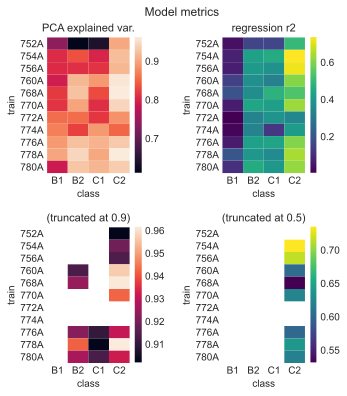

In [13]:
fig, axes = plt.subplots(ncols=2, nrows=2)
fig.set_size_inches(5, 6)
fig.subplots_adjust(wspace=0.7, hspace=0.4)
ax1, ax2, ax3, ax4 = axes.flatten()

explained = metrics.pivot(index='train', columns='class', values='explained')
r2 = metrics.pivot(index='train', columns='class', values='r2')

sns.heatmap(explained, ax=ax1)
ax1.set_title('PCA explained var.', fontsize=11)

sns.heatmap(r2, ax=ax2, cmap='viridis')
ax2.set_title('regression r2', fontsize=11)

explained = truncate_values(explained, th=0.9)
r2 = truncate_values(r2, th=0.5)

sns.heatmap(explained, ax=ax3)
ax3.set_title('(truncated at 0.9)', fontsize=11)

sns.heatmap(r2, ax=ax4, cmap='viridis')
ax4.set_title('(truncated at 0.5)', fontsize=11)

fig.suptitle('Model metrics', y=0.95)

plt.savefig('../data/figures/model_metrics.pdf', transparent=True, bbox_inches='tight')

In [14]:
trains = places.index.get_level_values(0).unique()
classes = places.index.get_level_values(1).unique()

fig, axes = plt.subplots(nrows=len(trains), ncols=len(classes))
fig.set_size_inches(3.5 * len(classes), 2.5 * len(trains))
fig.subplots_adjust(hspace=0.55, wspace=0.35)

for i, train in enumerate(trains):
    handles = []
    labels = []
    
    for j, class_ in enumerate(classes):
        ax = axes[i, j]
        model = models[(train, class_)]
        
        for k, dt in enumerate(model.index):
            weekday_id = dt.weekday()
            weekday = dt.strftime('%A')

            ax.scatter(model.places[k], model.prices[k], color=f'C{weekday_id}', label=weekday)

        ox = np.array([np.nanmin(model.places), np.nanmax(model.places)])
        ax.plot(ox, model.regression.b0 + model.regression.b1 * ox, c='black', ls='dashed', marker='None', zorder=5)
        
        ax.set_xlabel('places')
        ax.set_ylabel('price')
        ax.set_title(f'{train}, {class_}', fontsize=9)
        
        handles_, labels_ = ax.get_legend_handles_labels()
        handles.extend(handles_)
        labels.extend(labels_)
        
    if i % 3 == 0:
        legend = dict(zip(labels, handles))
        labels = list(weekdays.values())
        handles = [legend[label] for label in labels]
        
        ax.legend(handles, labels, loc='upper left', bbox_to_anchor=(1, 1))
        
plt.suptitle('Price vs. places', y=0.895)
        
plt.savefig('../data/figures/price_vs_places.pdf', transparent=True, bbox_inches='tight')
plt.close()

In [15]:
assert len(trains) == 11
colors = [f'C{i}' for i in range(10)]
colors.append('black')
colors = dict(zip(trains, colors))

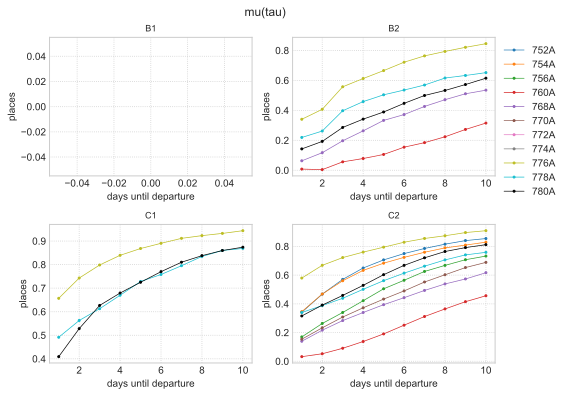

In [16]:
fig, axes = plt.subplots(nrows=2, ncols=2)
axes = axes.flatten()
fig.set_size_inches(8, 6)
fig.subplots_adjust(hspace=0.35)

for train in trains:
    for i, class_ in enumerate(classes):
        ax = axes[i]
        c = colors[train]
        model = models[(train, class_)]
        
        series = model.mean.copy()
        
        if model.explained_variance < 0.9:
            series *= np.nan
        
        ax.plot(series, c=c, label=train)
        ax.set_title(class_, fontsize=9)
        ax.set_xlabel('days until departure')
        ax.set_ylabel('places')

        if i == 1:
            ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
            
fig.suptitle('mu(tau)', y=0.95)

plt.savefig('../data/figures/pca_mu.pdf', transparent=True, bbox_inches='tight')

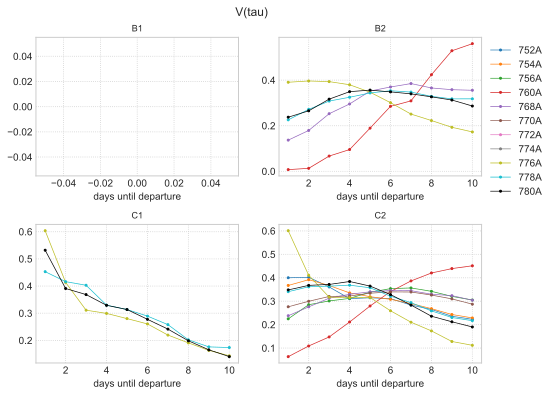

In [17]:
fig, axes = plt.subplots(nrows=2, ncols=2)
axes = axes.flatten()
fig.set_size_inches(8, 6)
fig.subplots_adjust(hspace=0.35)

for train in trains:
    for i, class_ in enumerate(classes):
        ax = axes[i]
        c = colors[train]
        model = models[(train, class_)]

        series = model.v.copy()
        
        if model.explained_variance < 0.9:
            series *= np.nan
        
        ax.plot(series, c=c, label=train)
        ax.set_title(class_, fontsize=9)
        ax.set_xlabel('days until departure')

        if i == 1:
            ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
            
fig.suptitle('V(tau)', y=0.95)

plt.savefig('../data/figures/pca_v.pdf', transparent=True, bbox_inches='tight')

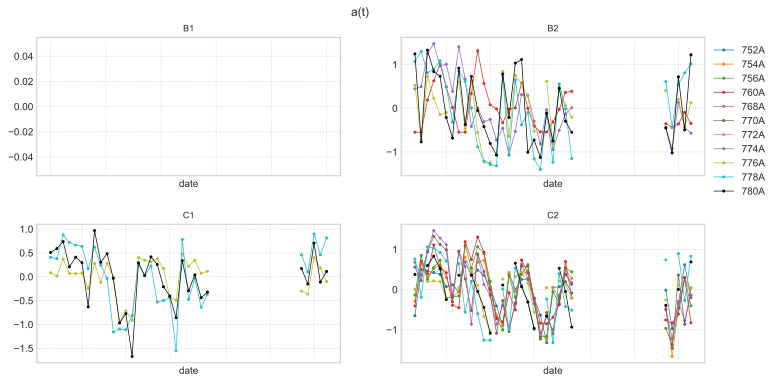

In [18]:
fig, axes = plt.subplots(nrows=2, ncols=2)
axes = axes.flatten()
fig.set_size_inches(12, 6)
fig.subplots_adjust(hspace=0.35)

for train in trains:
    for i, class_ in enumerate(classes):
        ax = axes[i]
        c = colors[train]
        model = models[(train, class_)]
        
        series = model.a.copy()
        
        if model.explained_variance < 0.9:
            series *= np.nan
        
        ax.plot(series, c=c, label=train)
        ax.set_title(class_, fontsize=9)
        ax.set_xlabel('date')
        ax.tick_params(axis='x', which='major', labelbottom=False)

        if i == 1:
            ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
            
fig.suptitle('a(t)', y=0.95)

plt.savefig('../data/figures/pca_a.pdf', transparent=True, bbox_inches='tight')